### 集成学习

#### boosting- Adaboosting

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [113]:
sns.set_style("whitegrid")

In [2]:
def get_simple_data():
    X = [[1, 2.1], [2, 1.1], [1.3, 1], [1, 1], [2, 1]]
    y = [1.0, 1.0, -1, -1, 1]
    return X, y

In [3]:
X,y=get_simple_data()
X,y

([[1, 2.1], [2, 1.1], [1.3, 1], [1, 1], [2, 1]], [1.0, 1.0, -1, -1, 1])

In [116]:
X=np.array(X)

In [117]:
y=np.array(y)

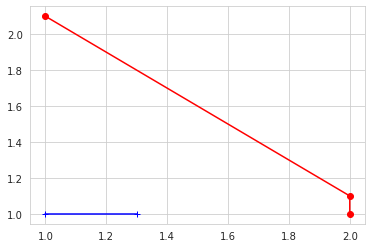

In [118]:
plt.plot(X[y==1,0],X[y==1,1],color='r',marker='o')
plt.plot(X[y==-1,0],X[y==-1,1],color='b',marker='+')

In [119]:
X[y==-1]

array([[1.3, 1. ],
       [1. , 1. ]])

In [5]:
def stump_classify(X_Mar, dimen, thresh_val, thresh_ineq):
    res = np.ones((np.shape(X_Mar)[0], 1))
    if thresh_ineq == 'lt':
        res[X_Mar[:, dimen] <= thresh_val] = -1.0
    else:
        res[X_Mar[:, dimen] > thresh_val] = -1.0
    return res

In [6]:
def build_strump(X, y, D):
    """
        构建最佳单层决策树
        X: 特征
        y: 标签
    """
    X = np.mat(X)
    y = np.mat(y).T
    m, n = np.shape(X)
    num_steps = 10.0
    # 最佳单层决策树
    best_stump = {}
    best_class_est = np.mat(np.zeros((m, 1)))
    min_error = np.inf
    for i in range(n):
        range_min = X[:, i].min()
        range_max = X[:, i].max()
        step_size = (range_max - range_min) / num_steps
        for j in range(-1, int(num_steps) + 1):
            for inequal in ['lt', 'gt']:
                thresh_val = (range_min + j * step_size)
                pred_vals = stump_classify(X, i, thresh_val, inequal)
                error_arr = np.mat(np.ones((m, 1)))
                error_arr[pred_vals == y] = 0
                weight = D.T * error_arr

                # 权重误差小于min,return
                if weight < min_error:
                    min_error = weight
                    best_class_est = pred_vals.copy()
                    best_stump['dim'] = i
                    best_stump['thresh'] = thresh_val
                    best_stump['ineq'] = inequal
    return best_stump, min_error, best_class_est

In [122]:
D=np.mat(np.ones((5,1))/5)
D

matrix([[0.2],
        [0.2],
        [0.2],
        [0.2],
        [0.2]])

In [123]:
build_strump(X,y,D)

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'}, matrix([[0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

##### 完整的adaboost
1. 初始化权值
2. 遍历所有特征
    - 2.1 使用初始化权值分布的训练集学习得到基学习器
    - 2.2 计算基学习器的误差率
    - 2.3 计算G(m)的系数
    - 2.4 更新样本权重系数
3. 输出模型

In [15]:
def adaboost(X, y, iter_nums=40, debug=False):
    weak_class = []
    m = np.shape(X)[0]
    # 1. init D
    D = np.mat(np.ones((m, 1)) / m)
    agg_class_est = np.mat(np.zeros((m, 1)))
    error_rate = 0.0
    for i in range(iter_nums):
        best_stump, error, class_est = build_strump(X, y, D)
        if debug:
            print("D.T: ", D.T)
        #calc alpha, throw in max(error,eps) to account for error=0
        alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))
        if debug:
            print("alpha:\n", alpha)
        best_stump['alpha'] = alpha
        #store Stump Params in Array
        weak_class.append(best_stump)
        if debug:
            print("class_est:", class_est.T)
        #exponent for D calc, getting messy
        expon = np.multiply(-1 * alpha * np.mat(y).T, class_est)
        #Calc New D for next iteration
        D = np.multiply(D, np.exp(expon))
        D /= D.sum()
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        agg_class_est += alpha * class_est
        if debug:
            print("agg_class_est:", agg_class_est.T)
        agg_errors = np.multiply(
            np.sign(agg_class_est) != np.mat(y).T, np.ones((m, 1)))
        if debug:
            print("agg_errors:", agg_errors)
        error_rate = agg_errors.sum() / m
        if debug:
            print("total_error:", error_rate)
        if error_rate == 0.0:
            break
    return weak_class, agg_class_est, error_rate

In [16]:
# y_test [1. -1. -1. 1. 1.]
# item1: err仅有第一个分错，给第一个数据点0.5的weight
# item2: err第一个点已正确分类，最后一点错误，赋予weight 0.5
# item3：error=0,终止
eak_class, agg_class_est, error_rate = adaboost(X, y, iter_nums=9, debug=True)
weak_class, agg_class_est, error_rate

D.T:  [[0.2 0.2 0.2 0.2 0.2]]
alpha:
 0.6931471805599453
class_est: [[-1.  1. -1. -1.  1.]]
agg_class_est: [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
agg_errors: [[1.]
 [0.]
 [0.]
 [0.]
 [0.]]
total_error: 0.2
D.T:  [[0.5   0.125 0.125 0.125 0.125]]
alpha:
 0.9729550745276565
class_est: [[ 1.  1. -1. -1. -1.]]
agg_class_est: [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
agg_errors: [[0.]
 [0.]
 [0.]
 [0.]
 [1.]]
total_error: 0.2
D.T:  [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
alpha:
 0.8958797346140273
class_est: [[1. 1. 1. 1. 1.]]
agg_class_est: [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
agg_errors: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
total_error: 0.0


([{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453},
  {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565},
  {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}],
 matrix([[ 1.17568763],
         [ 2.56198199],
         [-0.77022252],
         [-0.77022252],
         [ 0.61607184]]),
 0.0)

In [19]:
def adaboost_classify(X, classifier_arr):
    # do stuff similar to last aggClassEst in adaBoostTrainDS
    X = np.mat(X)  #
    m = np.shape(X)[0]
    agg_class_est = np.mat(np.zeros((m, 1)))
    for i in range(len(classifier_arr)):
        class_est = stump_classify(X,classifier_arr[i]['dim'],\
                                 classifier_arr[i]['thresh'],\
                                 classifier_arr[i]['ineq'])#call stump classify
        agg_class_est += classifier_arr[i]['alpha'] * class_est
        #print(agg_class_est)
    return np.sign(agg_class_est)

In [127]:
y_pred=adaboost_classify(X,weak_class)
y_pred

matrix([[ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]])

In [128]:
y_pred

matrix([[ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]])

In [129]:
y

array([ 1.,  1., -1., -1.,  1.])

In [130]:
adaboost_classify([0,0],weak_class)

matrix([[-1.]])

In [131]:
adaboost_classify([[5,5],[0,0]],weak_class)

matrix([[ 1.],
        [-1.]])

In [132]:
!ls datasets/

dating_test1.txt  email		      horseColicTraining.txt  svm_RBF2.txt
dating_test.txt   horse-colic.data    housing.csv	      svm_RBF.txt
digits		  horseColicTest.txt  play		      svm.txt


In [133]:
horse_train=pd.read_csv("datasets/horseColicTraining.txt",sep='\t',header=None).to_numpy()
X_train,y_train=horse_train[:,:-1],horse_train[:,-1]

In [9]:
def get_data(file_path):
    horse_train = pd.read_csv(file_path, sep='\t', header=None).to_numpy()
    X, y = horse_train[:, :-1], horse_train[:, -1]
    y[y == 0] = -1
    return X, y

In [11]:
X_train,y_train=get_data("datasets/horseColicTraining.txt")
X_train,y_train[:10]

(array([[ 2. ,  1. , 38.5, ...,  8.4,  0. ,  0. ],
        [ 1. ,  1. , 39.2, ..., 85. ,  2. ,  2. ],
        [ 2. ,  1. , 38.3, ...,  6.7,  0. ,  0. ],
        ...,
        [ 1. ,  1. , 37.5, ...,  6.8,  0. ,  0. ],
        [ 1. ,  1. , 36.5, ...,  6. ,  3. ,  3.4],
        [ 1. ,  1. , 37.2, ..., 62. ,  1. ,  1. ]]),
 array([-1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.]))

In [12]:
X_test,y_test=get_data("datasets/horseColicTest.txt")
X_test,y_test[:10]

(array([[ 2. ,  1. , 38.5, ...,  6.3,  0. ,  0. ],
        [ 2. ,  1. , 37.6, ...,  6.3,  1. ,  5. ],
        [ 1. ,  1. , 37.7, ..., 70. ,  3. ,  2. ],
        ...,
        [ 1. ,  1. , 38. , ..., 65. ,  3. ,  2. ],
        [ 2. ,  1. , 38. , ...,  5.8,  0. ,  0. ],
        [ 2. ,  1. , 37.6, ...,  6. ,  0. ,  0. ]]),
 array([ 1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.]))

In [17]:
### 训练数据
# total_error: 0.2842809364548495
weak_class_1, _, err_rate_1 = adaboost(X_train, y_train, 1)
# [{'dim': 9, 'thresh': 3.0, 'ineq': 'gt', 'alpha': 0.4616623792657674}]
weak_class_1, err_rate_1

([{'dim': 9, 'thresh': 3.0, 'ineq': 'gt', 'alpha': 0.4616623792657674}],
 0.2842809364548495)

In [20]:
from sklearn.metrics import accuracy_score
y_pred_horse=adaboost_classify(X_test,weak_class_1)
# 0.7313432835820896
accuracy_score(y_test,y_pred_horse)

0.7313432835820896

In [140]:
X_train.shape

(299, 21)

In [141]:
X_test.shape,y_test.shape

((67, 21), (67,))

In [25]:
def analysics_ada(iter_num=10):
    weak_class, _, error_rate = adaboost(X_train, y_train, iter_num)
    y_pred_horse = adaboost_classify(X_test, weak_class)
   
    return error_rate, accuracy_score(y_test, y_pred_horse)

In [27]:
%%time
# 弱分类器数目
test_iter_nums=[1,10,50,100,500,1000,10000] # 
for i in test_iter_nums:
    print("item ",i)
    print(analysics_ada(i))

item  1
(0.2842809364548495, 0.7313432835820896)
item  10
(0.23076923076923078, 0.7611940298507462)
item  50
(0.18729096989966554, 0.7910447761194029)
item  100
(0.19063545150501673, 0.7761194029850746)
item  500
(0.15719063545150502, 0.746268656716418)
item  1000
(0.14046822742474915, 0.6865671641791045)
item  10000
(0.11036789297658862, 0.6716417910447762)
CPU times: user 3min 30s, sys: 1.55 ms, total: 3min 30s
Wall time: 3min 32s


In [30]:
# 通常情况下，AdaBoost会达到一个稳定的测试错误率，而并不会随着分类器的数目增多而提高，训练错误率会不断的降低？
# 寻找该数据集最稳定的精确度 50-100
def get_max_error_rate():
    _accuracy = 0.7910447761194029
    for i in range(51, 100):
        err, t_accuracy = analysics_ada(i)
        print("item: %s, acc: %s" % (i, t_accuracy))
        if t_accuracy > _accuracy:
            _accuracy = t_accuracy
    return _accuracy

In [31]:
#0.8059701492537313 item 58 差别不是很大嘛
# 数据集本身缺失30%左右，对决策树算法有很大影响，适当处理一下数据集 ???
# 实际检测数据没有缺失值？
get_max_error_rate()

item: 0.1939799331103679, acc: 0.7910447761194029
item: 0.18394648829431437, acc: 0.7910447761194029
item: 0.1939799331103679, acc: 0.7910447761194029
item: 0.18394648829431437, acc: 0.7910447761194029
item: 0.1939799331103679, acc: 0.7910447761194029
item: 0.19063545150501673, acc: 0.7910447761194029
item: 0.19732441471571907, acc: 0.7910447761194029
item: 0.1939799331103679, acc: 0.8059701492537313
item: 0.18729096989966554, acc: 0.7910447761194029
item: 0.18729096989966554, acc: 0.8059701492537313
item: 0.1939799331103679, acc: 0.8059701492537313
item: 0.1939799331103679, acc: 0.8059701492537313
item: 0.1939799331103679, acc: 0.7910447761194029
item: 0.1939799331103679, acc: 0.7910447761194029
item: 0.1939799331103679, acc: 0.7910447761194029
item: 0.19063545150501673, acc: 0.7910447761194029
item: 0.18729096989966554, acc: 0.7910447761194029
item: 0.19063545150501673, acc: 0.7910447761194029
item: 0.19063545150501673, acc: 0.7910447761194029
item: 0.1939799331103679, acc: 0.7910447

0.8059701492537313

In [32]:
def get_orgin_date(file_path):
    return pd.read_csv(file_path, sep='\t', header=None)

In [33]:
train_data_path="datasets/horseColicTraining.txt"
train_data=get_orgin_date(train_data_path)
train_data

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,2.0,1.0,38.5,66.0,28.0,3.0,3.0,0.0,2.0,5.0,...,0.0,0.0,0.0,3.0,5.0,45.0,8.4,0.0,0.0,0.0
1,1.0,1.0,39.2,88.0,20.0,0.0,0.0,4.0,1.0,3.0,...,0.0,0.0,0.0,4.0,2.0,50.0,85.0,2.0,2.0,0.0
2,2.0,1.0,38.3,40.0,24.0,1.0,1.0,3.0,1.0,3.0,...,0.0,0.0,0.0,1.0,1.0,33.0,6.7,0.0,0.0,1.0
3,1.0,9.0,39.1,164.0,84.0,4.0,1.0,6.0,2.0,2.0,...,1.0,2.0,5.0,3.0,0.0,48.0,7.2,3.0,5.3,0.0
4,2.0,1.0,37.3,104.0,35.0,0.0,0.0,6.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,74.0,7.4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,1.0,1.0,0.0,120.0,70.0,4.0,0.0,4.0,2.0,2.0,...,0.0,0.0,0.0,0.0,5.0,55.0,65.0,0.0,0.0,0.0
295,2.0,1.0,37.2,72.0,24.0,3.0,2.0,4.0,2.0,4.0,...,3.0,1.0,0.0,4.0,4.0,44.0,0.0,3.0,3.3,0.0
296,1.0,1.0,37.5,72.0,30.0,4.0,3.0,4.0,1.0,4.0,...,2.0,1.0,0.0,3.0,5.0,60.0,6.8,0.0,0.0,0.0
297,1.0,1.0,36.5,100.0,24.0,3.0,3.0,3.0,1.0,3.0,...,3.0,1.0,0.0,4.0,4.0,50.0,6.0,3.0,3.4,1.0


In [37]:
train_data[0].describe()

count    299.000000
mean       1.397993
std        0.490305
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: 0, dtype: float64

In [41]:
train_data[train_data.isnull()]

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
deal_train_data=train_data.copy()
deal_train_data.dropna(how="any")
deal_train_data.shape

(299, 22)

In [45]:
train_data.shape

(299, 22)

In [49]:
a_test = [[1, np.nan, 2],[np.nan,None,np.nan],[3, None, None],[5,None,7],[1,2,3]]
a_test=pd.DataFrame(a_test)
a_test

,0,1,2
0,1.0,NaN,2.0
1,NaN,NaN,NaN
2,3.0,NaN,NaN
3,5.0,NaN,7.0
4,1.0,2.0,3.0


In [54]:
a_test.dropna(how="any").shape

(1, 3)

In [53]:
a_test.shape

(5, 3)

##### adaboost 面向对象写法

In [ ]:
class ThreshClassifier():
    def __init__(self):
        self.v = 0
        # 取值方向
        self.direction = 0

    def fit(self, X, y, weight):
        #X = np.mat(X)
        #y = np.mat(y).T
        loss = 0
        min_loss = 1
        for v in np.arange(0.5, 10):
            for direction in [0, 1]:
                miss_value = ((X > v) - 0.5) * 2 != y if direction else (
                    (X < v) - 0.5) * 2 != y
                loss = np.sum(miss_value * weight)
                if loss < min_loss:
                    min_loss = loss
                    self.v = v
                    self.direction = direction
        return min_loss

    def predict(self, X):
        return ((X > self.v) - 0.5) * 2 if self.direction else (
            (X < self.v) - 0.5) * 2

In [ ]:
class AdaBoost():
    def __init__(self, classifier=ThreshClassifier):
        self.classifier = classifier
        self.classifiers = []
        self.alphas = []

    def fit(self, X, y):
        n = X.shape[0]
        M = 3
        w_m = np.mat([1 / n] * n)
        for m in range(M):
            classifier_m = self.classifier()
            e_m = classifier_m.fit(X, y, w_m)
            print(e_m)
            alpha_m = 1.0 / 2 * np.log((1 - e_m) / e_m)
            w_m = w_m * np.exp(-alpha_m * y * classifier_m.predict(X))
            z_m = np.sum(w_m)
            w_m = w_m / z_m
            print(w_m)
            self.classifiers.append(classifier_m)
            self.alphas.append(alpha_m)

    def predict(self, X):
        n = X.shape[0]
        results = np.zeros(n)
        for alpha, classifier in zip(self.alphas, self.classifiers):
            results += alpha * classifier.predict(X)
        return ((results > 0) - 0.5) * 2

In [6]:
X = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
y = [1, 1, 1, -1, -1, -1, 1, 1, 1, -1]
X = np.array(X)
y = np.array(y)
X, y

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 1,  1,  1, -1, -1, -1,  1,  1,  1, -1]))

In [31]:
ada_b=AdaBoost()
ada_b.fit(X,y)
ada_b.predict(X)

ValueError: shapes (10,10) and (1,10) not aligned: 10 (dim 1) != 1 (dim 0)